Business problems
- Detect anomalies in refrigeration temperatures (includes a defrost cycle and more than basic limits)
- Determine energy performance (temperatures (fridge and environmental) and current)
- Potential energy savings (RL?)

Process
- Data ingestion pipeline for training
- EDA & ML for building models (averages for feature engineering?)
- API for deployment (real-time?)

In [2]:
import sys
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import seaborn as sns

%matplotlib inline
sns.set(rc={"figure.figsize": (26, 10)})

In [3]:
sys.path.append("../")
from cnrdlib import cl_plots as clp

In [5]:
df_meta = pd.read_csv("../data/sensors_sensor_202107282041.csv", parse_dates=True, index_col="sensor_id")
df_meta.head(15)

,sensor_name,sensor_description,sensor_type,sensor_ucl,sensor_lcl,sensor_created_date,sensor_modified_date,sensor_state,sensor_llcl,sensor_uucl,...,sensor_critical_active,sensor_uom,sensor_lspec,sensor_uspec,sensor_report_id,sensor_register,device_name_id,sensor_order_id,sensor_tolerance,sensor_show_matrix
sensor_id,,,,,,,,,,,,,,,,,,,,,
24,New cold room temperature [2],NaN,Temperature,NaN,NaN,2021-03-27 21:06:43.574897000,2021-03-28 11:17:00.330146000,active,NaN,NaN,...,0,°C,NaN,NaN,1,3,9,1,5.0,1
25,WIP temperature probe,NaN,Temperature,NaN,NaN,2021-03-28 11:18:28.285837000,2021-04-21 09:52:36.092212000,active,NaN,NaN,...,0,°C,NaN,NaN,1,1,9,2,10.0,1
26,WIP cold room temperature [2],NaN,Temperature,NaN,NaN,2021-03-28 11:19:22.187758000,2021-04-21 09:52:18.396540000,active,NaN,NaN,...,0,°C,NaN,NaN,1,2,9,3,10.0,1
27,High-risk prep temperature,NaN,Temperature,NaN,NaN,2021-03-28 11:20:35.748534000,2021-03-28 11:20:35.748680000,active,NaN,NaN,...,0,°C,NaN,NaN,1,1,10,4,5.0,1
28,Low-risk prep temperature,NaN,Temperature,NaN,NaN,2021-03-28 11:21:13.365155000,2021-03-28 11:21:13.365253000,active,NaN,NaN,...,0,°C,NaN,NaN,1,2,10,5,5.0,1
29,WIP cold room temperature [1],NaN,Temperature,8.5,0.0,2021-03-28 11:21:42.891440000,2021-03-30 10:30:42.631335000,active,-2.0,10.0,...,1,°C,0.0,5.0,1,3,10,6,5.0,1
30,Dispatch cold room temperature,NaN,Temperature,8.5,0.0,2021-03-28 11:22:12.671387000,2021-04-21 09:52:51.067454000,active,-2.0,10.0,...,1,°C,0.0,5.0,1,4,10,7,10.0,1
31,External temperature,NaN,Temperature,NaN,NaN,2021-03-28 11:22:35.509809000,2021-03-28 11:22:35.509904000,active,NaN,NaN,...,0,°C,NaN,NaN,1,5,10,8,5.0,1
32,New cold room temperature [2],NaN,Temperature,NaN,NaN,2021-03-28 11:23:06.673252000,2021-03-28 11:23:06.673420000,active,NaN,NaN,...,0,°C,NaN,NaN,1,6,10,9,5.0,1


In [7]:
import_file = "../data/raw/sensor_data_log_20210419.gz"

In [8]:
df = pd.read_csv(import_file, compression="gzip", parse_dates=True)
df.head()

,timestamp,value,sensor_id_id
0,2021-04-19 00:00:02.656269,12.93,24
1,2021-04-19 00:00:02.656269,4.38,25
2,2021-04-19 00:00:02.656269,0.93,26
3,2021-04-19 00:00:03.887105,16.75,27
4,2021-04-19 00:00:03.887105,17.37,28


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60385 entries, 0 to 60384
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     60385 non-null  object 
 1   value         60385 non-null  float64
 2   sensor_id_id  60385 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.4+ MB


In [10]:
df.timestamp = df.timestamp.astype("datetime64[ns]")

In [11]:
df.sensor_id_id.unique()

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], dtype=int64)

In [12]:
df_sensor = df[["timestamp", "value"]][df.sensor_id_id == 29]
df_sensor.set_index("timestamp", inplace=True)
df_sensor.head()

,value
timestamp,
2021-04-19 00:00:03.887105,1.56
2021-04-19 00:00:29.779445,1.37
2021-04-19 00:00:46.660436,1.43
2021-04-19 00:01:03.535178,1.62
2021-04-19 00:01:25.293661,1.81


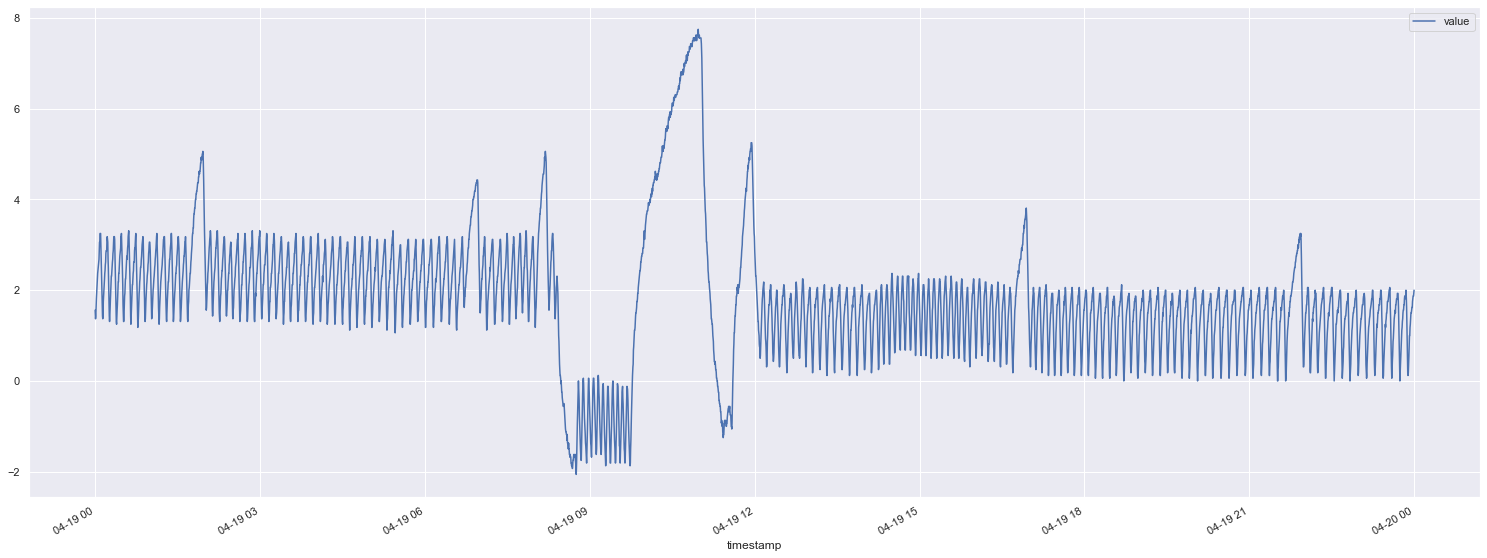

In [13]:
df_sensor.plot();

In [14]:
df_sensor_5min = df_sensor.resample("5min").mean()
df_sensor_5min.head()

,value
timestamp,
2021-04-19 00:00:00,2.202500
2021-04-19 00:05:00,2.284118
2021-04-19 00:10:00,2.718125
2021-04-19 00:15:00,2.140000
2021-04-19 00:20:00,2.216471


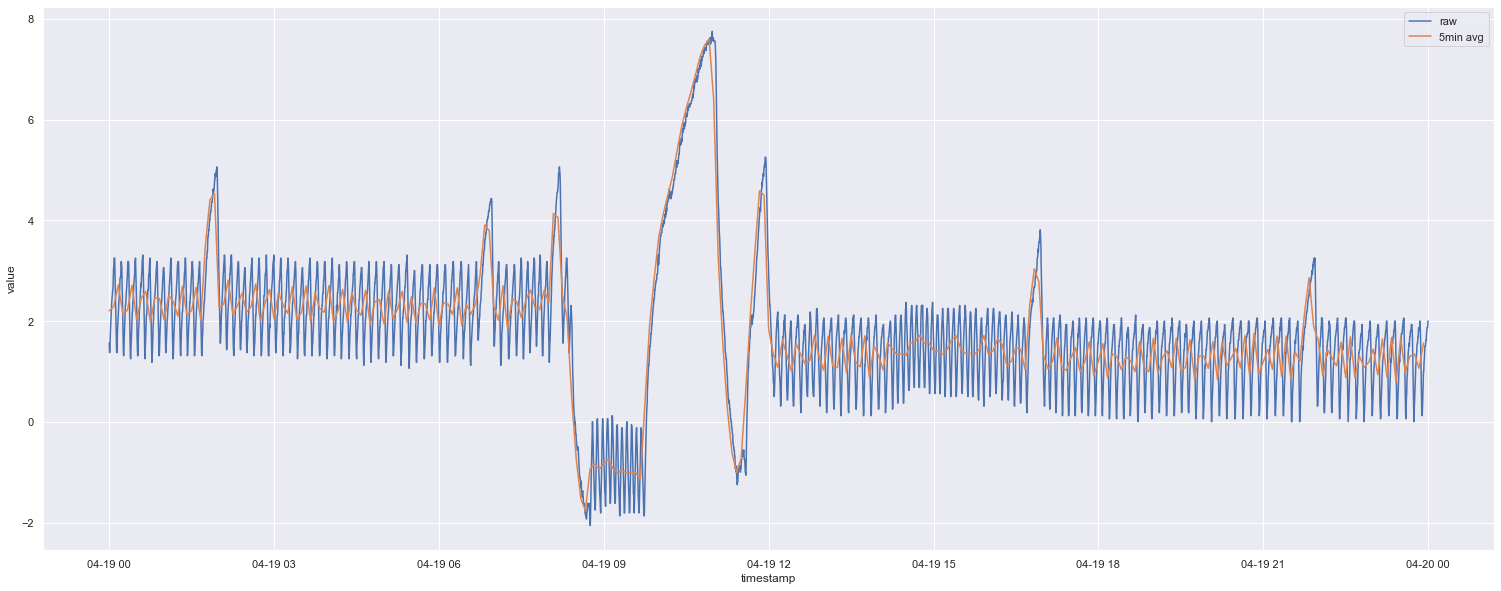

In [15]:
sns.lineplot(x=df_sensor.index, y="value", data=df_sensor, label="raw")
sns.lineplot(x=df_sensor_5min.index, y="value", data=df_sensor_5min, label="5min avg");